<a href="https://colab.research.google.com/github/arvchak/MLProj/blob/main/protonetwork_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
#!pip install tensornets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import pathlib
from PIL import Image
from numpy.linalg import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/new_train.zip

Archive:  /content/drive/MyDrive/new_train.zip
replace new_train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
root_path = '/content/new_train'
output = '/content/new_train'

In [ ]:
data_dir = pathlib.Path(root_path)
count =  len(list(data_dir.glob('*/*.jpg')))
print(count)

0


In [ ]:
#!pip install split-folders
##import splitfolders
#splitfolders.ratio(root_path , output , seed = 42 , ratio = (.7, .2 ,.1), group_prefix = None)

In [ ]:
data_dir_train = pathlib.Path(output+'/train')
data_dir_test = pathlib.Path(output+'/test')
data_dir_val = pathlib.Path(output+'/val')

In [ ]:
batch_size = 45
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 23100 files belonging to 33 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 8400 files belonging to 12 classes.


In [ ]:
class_names = train_ds.class_names
val_class_names = val_ds.class_names
print(class_names)
no_of_classes = len(class_names)
no_val_classes = len(val_class_names)
#train_np = np.stack(list(train_ds))

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'storage_tank', 'tennis_court', 'terrace']


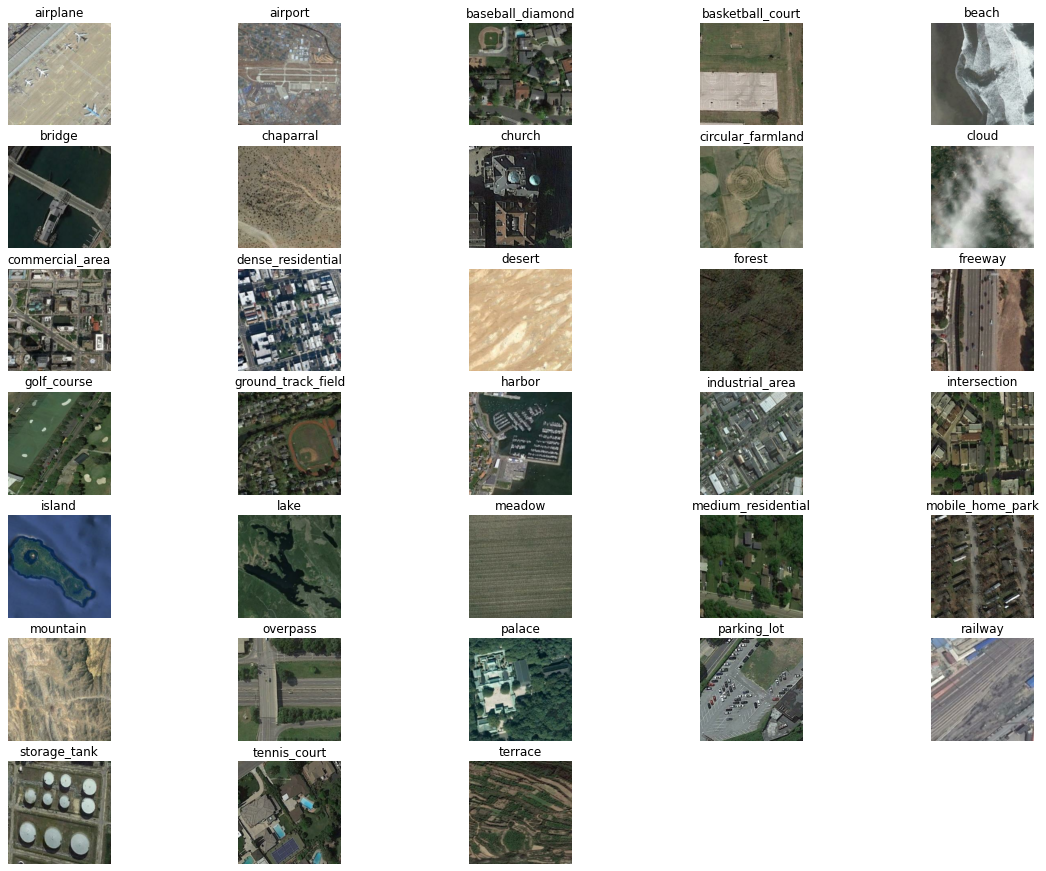

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
j = 0
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(9, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [ ]:
#train_dataset = np.zeros([no_of_classes, 3, img_height, img_width], dtype=object)
examples = np.zeros([no_of_classes, 700, img_height, img_width,3], dtype=np.float32)
for train in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], train))
  for image, label in filtered_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_train , class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      examples[label.numpy()[0], index] = values


In [ ]:
test_data = np.zeros([no_val_classes, 700, img_height, img_width,3], dtype=np.float32)
for val in range(len(val_class_names)):
  filtered_val_ds = val_ds.filter(lambda x, l: tf.math.equal(l[0], val))
  for image, label in filtered_val_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_val , val_class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      test_data[label.numpy()[0], index] = values


In [ ]:
sample_img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


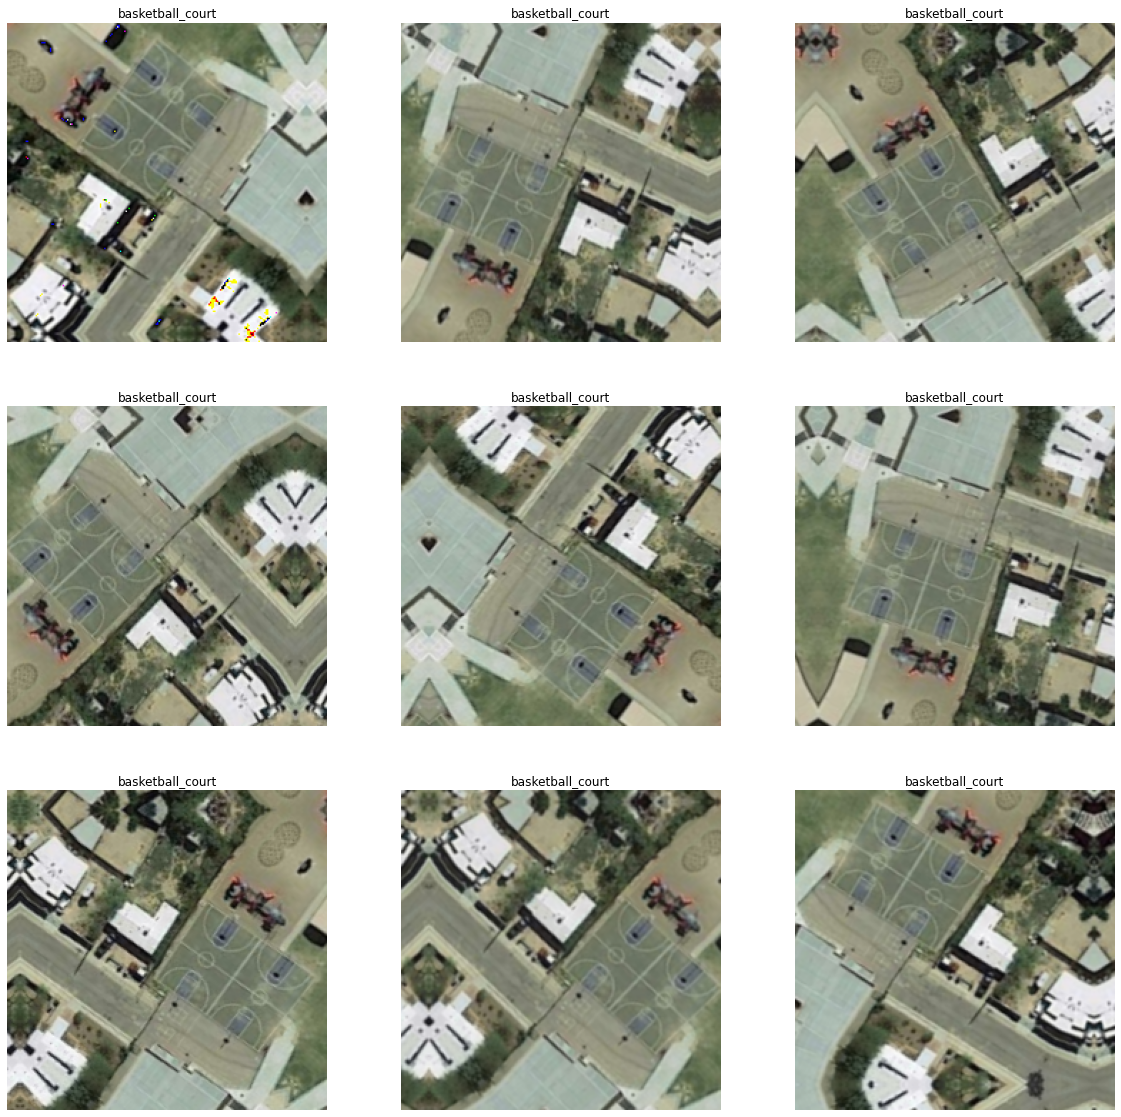

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = sample_img_augmentation(image)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[label.numpy()[0]])
        plt.axis("off")

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [ ]:
def base_model(inputs, h_dim , z_dim):
    layer_inputs = layers.Input(tensor = inputs)
    #x = img_augmentation(inputs)
    x = img_augmentation(layer_inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
       # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)

    net = cnn(inputs, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    

    # Rebuild top
    return tf.concat([x, net], axis = 1)

In [ ]:
def cnn(inputs, op_channels):
    conv = tf.compat.v1.layers.conv2d(inputs, op_channels, kernel_size=3, padding='SAME')
    conv = tf.compat.v1.layers.batch_normalization(conv,scale=True, center=True)
    conv = tf.nn.swish(conv)
    conv = tf.compat.v1.layers.max_pooling2d(conv, strides = 2, pool_size=2, padding = 'SAME')
    return conv

In [ ]:
#number of classes
num_way = 5

#number of examples per class for support set
num_shot = 5

#number of query points
num_query = 5

#number of examples
num_examples = 10

channel = 3

h_dim = 64

z_dim = 64

In [ ]:
support_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
query_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
label = tf.compat.v1.placeholder(tf.int64, [None, None])

In [ ]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)


In [ ]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [ ]:
num_query_points = query_set_shape[1]

In [ ]:
y = tf.compat.v1.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)
print(y_one_hot.shape)


label_prime = tf.one_hot(label , depth = num_classes)

(None, None, None)


In [ ]:
#output = build_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]))
support_set_embeddings = base_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]), h_dim, z_dim)

Instructions for updating:
Colocations handled automatically by placer.
16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]
class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [ ]:
#query_output = build_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]))
query_set_embeddings = base_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
   
    

In [ ]:
print(query_set_embeddings.shape)
print(class_prototype.shape)

distance = euclidean_distance(query_set_embeddings,class_prototype)
print(distance)

predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_probability, axis=-1), y), tf.float32))

train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


(None, 13824)
(None, 13824)
Tensor("Mean_1:0", shape=(None, None), dtype=float32)


In [ ]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()
sess.run(init)

In [ ]:
num_epochs = 32
num_episodes = 100
train_accuracy_over_epochs = []
train_loss_over_epochs = []
test_accuracy_over_epochs = []
test_loss_over_epochs = []

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = examples[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = examples[class_, selected[num_shot:]]
            
        #=support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        train_accuracy_over_epochs.append(accuracy_)
        train_loss_over_epochs.append(loss_)
        if (episode+1) % 100 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 100 : Loss: 1.6378899812698364, Accuracy: 0.3199999928474426
Epoch 2 : Episode 100 : Loss: 1.0568766593933105, Accuracy: 0.47999998927116394
Epoch 3 : Episode 100 : Loss: 1.394076943397522, Accuracy: 0.5199999809265137
Epoch 4 : Episode 100 : Loss: 1.0307340621948242, Accuracy: 0.6800000071525574
Epoch 5 : Episode 100 : Loss: 1.478718876838684, Accuracy: 0.4399999976158142
Epoch 6 : Episode 100 : Loss: 1.342713475227356, Accuracy: 0.2800000011920929
Epoch 7 : Episode 100 : Loss: 1.196067452430725, Accuracy: 0.4000000059604645
Epoch 8 : Episode 100 : Loss: 0.7005679607391357, Accuracy: 0.7599999904632568
Epoch 9 : Episode 100 : Loss: 0.7598132491111755, Accuracy: 0.6399999856948853
Epoch 10 : Episode 100 : Loss: 1.3962433338165283, Accuracy: 0.36000001430511475
Epoch 11 : Episode 100 : Loss: 0.9846366047859192, Accuracy: 0.6399999856948853
Epoch 12 : Episode 100 : Loss: 1.2230820655822754, Accuracy: 0.3199999928474426
Epoch 13 : Episode 100 : Loss: 0.49191293120384216,

In [ ]:

n_test_episodes = 3000
n_test_way = 5
n_test_shot = 5
n_test_query = 5
n_test_classes = test_data.shape[0]


In [ ]:
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test_accuracy_over_epochs.append(ac)
        test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 2.4362363815307617, Accuracy: 0.4000000059604645
Episode 20 : Loss: 1.9256134033203125, Accuracy: 0.36000001430511475
Episode 30 : Loss: 1.7772408723831177, Accuracy: 0.5199999809265137
Episode 40 : Loss: 3.6297905445098877, Accuracy: 0.3199999928474426
Episode 50 : Loss: 2.2294418811798096, Accuracy: 0.47999998927116394
Episode 60 : Loss: 3.4590392112731934, Accuracy: 0.36000001430511475
Episode 70 : Loss: 2.2211244106292725, Accuracy: 0.5199999809265137
Episode 80 : Loss: 1.5161826610565186, Accuracy: 0.4399999976158142
Episode 90 : Loss: 2.6394336223602295, Accuracy: 0.5199999809265137
Episode 100 : Loss: 2.685868740081787, Accuracy: 0.4000000059604645
Episode 110 : Loss: 1.854742407798767, Accuracy: 0.4000000059604645
Episode 120 : Loss: 1.6989566087722778, Accuracy: 0.4399999976158142
Episode 130 : Loss: 2.526984930038452, Accuracy: 0.2800000011920929
Episode 140 : Loss: 2.1858911514282227, Accuracy: 0.4399999976158142
Episode 150 : Loss: 1.5833779573440552, Acc

In [37]:

n_test_episodes = 3000
n_test_way = 5
n_test_shot = 3
n_test_query = 5
n_test_classes = test_data.shape[0]
test1_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test1_accuracy_over_epochs.append(ac)
        #test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 3.5226128101348877, Accuracy: 0.2800000011920929
Episode 20 : Loss: 3.837373733520508, Accuracy: 0.36000001430511475
Episode 30 : Loss: 2.4646434783935547, Accuracy: 0.47999998927116394
Episode 40 : Loss: 2.4847824573516846, Accuracy: 0.3199999928474426
Episode 50 : Loss: 2.0229997634887695, Accuracy: 0.4000000059604645
Episode 60 : Loss: 3.5158333778381348, Accuracy: 0.4399999976158142
Episode 70 : Loss: 2.328857183456421, Accuracy: 0.2800000011920929
Episode 80 : Loss: 2.8261337280273438, Accuracy: 0.47999998927116394
Episode 90 : Loss: 3.277412176132202, Accuracy: 0.11999999731779099
Episode 100 : Loss: 2.4890434741973877, Accuracy: 0.47999998927116394
Episode 110 : Loss: 2.5089430809020996, Accuracy: 0.3199999928474426
Episode 120 : Loss: 2.506700277328491, Accuracy: 0.36000001430511475
Episode 130 : Loss: 2.386667251586914, Accuracy: 0.4000000059604645
Episode 140 : Loss: 3.211411476135254, Accuracy: 0.2800000011920929
Episode 150 : Loss: 3.0098302364349365, Acc

In [38]:
n_test_episodes = 3000
n_test_way = 5
n_test_shot = 1
n_test_query = 5
n_test_classes = test_data.shape[0]
test2_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test2_accuracy_over_epochs.append(ac)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 2.9698758125305176, Accuracy: 0.4000000059604645
Episode 20 : Loss: 12.874032020568848, Accuracy: 0.3199999928474426
Episode 30 : Loss: 6.724438667297363, Accuracy: 0.11999999731779099
Episode 40 : Loss: 7.446953296661377, Accuracy: 0.23999999463558197
Episode 50 : Loss: 9.252328872680664, Accuracy: 0.3199999928474426
Episode 60 : Loss: 5.889379501342773, Accuracy: 0.3199999928474426
Episode 70 : Loss: 4.832233905792236, Accuracy: 0.1599999964237213
Episode 80 : Loss: 8.329394340515137, Accuracy: 0.20000000298023224
Episode 90 : Loss: 10.805279731750488, Accuracy: 0.3199999928474426
Episode 100 : Loss: 4.071084976196289, Accuracy: 0.2800000011920929
Episode 110 : Loss: 5.269434928894043, Accuracy: 0.36000001430511475
Episode 120 : Loss: 5.871203422546387, Accuracy: 0.23999999463558197
Episode 130 : Loss: 3.07490611076355, Accuracy: 0.36000001430511475
Episode 140 : Loss: 6.7133331298828125, Accuracy: 0.11999999731779099
Episode 150 : Loss: 12.153592109680176, Accurac

In [ ]:
sess.close()

In [39]:
np.mean(train_accuracy_over_epochs[0::100])

0.65375

In [42]:
import math 
Z = 1.960
N = 32 
mean = np.mean(test_accuracy_over_epochs[0::100])
SE = np.std(test_accuracy_over_epochs[0::100]) / len(test_accuracy_over_epochs[0::100])
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.41199997+/-0.03417243599953917


In [46]:
Z = 1.960
N = 32
mean = np.mean(test1_accuracy_over_epochs[0::100])
SE = np.std(test1_accuracy_over_epochs[0::100]) / len(test1_accuracy_over_epochs[0::100])
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.38625002+/-0.038208906189154436


In [47]:
Z = 1.960
N = 32
mean = np.mean(test2_accuracy_over_epochs[0::100])
SE = np.std(test2_accuracy_over_epochs[0::100]) / len(test2_accuracy_over_epochs[0::100])
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.30374998+/-0.03713336524010759


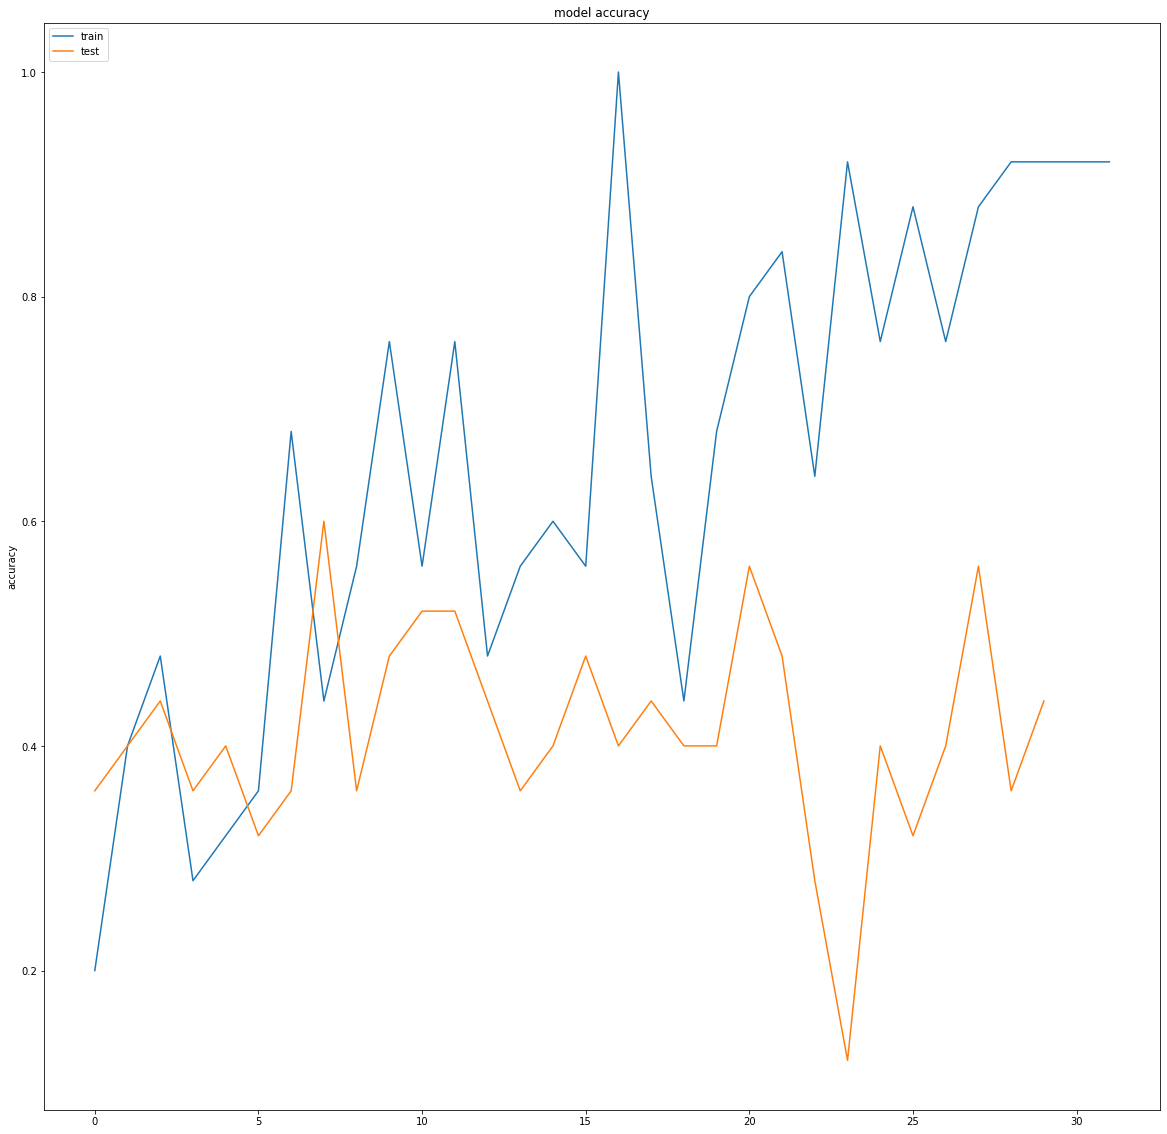

In [48]:
plt.figure(figsize=(20, 20))

plt.plot(train_accuracy_over_epochs[0::100])
plt.plot(test_accuracy_over_epochs[0::100])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()